### Test N2 from alchemy

##### Calculate path H$_2$ $\rightarrow$ N$_2$, since then $\epsilon_{\text{h}}$ always well defined

$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = -110.74

$\Delta E_{\rm{ref}}$ = -107.71

$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = -3.04

deviation from reference value somewhat smaller than for vac $\rightarrow$ N$_2$ (-3.14 Ha), but could also be because the path is shorter

##### What is the error for integration between adjacent elements?
around 400mHa for everyting except for intervals involving He2
largest error for intervals involving He2 
sudden change in e_homo from He2 to Li2 probably not main problem because for H2$\rightarrow$He2 large error as well although change in e_homo very smooth

e_homo is not the main issue

#### SI
integration by trapezoidal rule

$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = -110.56

$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = -2.85

In [1]:
import numpy as np
import scipy as sc
import numpy
import pyscf
import pyscf.gto
import pyscf.qmmm
import pyscf.scf
import pyscf.dft
import pyscf.lib
from pyscf.data import nist
import qml
from matplotlib import pyplot as plt
from IPython.display import display, Markdown


angstrom = 1 / 0.52917721067

In [2]:
def generate_mol(el, d, basis, total_elec, num_elec):
    mol = pyscf.gto.Mole()
    mol.atom = f'{el} 0 0 0; {el} 0 0 {d}'
    mol.basis = basis
    mol.charge = total_elec - num_elec
    mol.verbose = 0
    mol.build()
    return(mol)

def pyscf_APDFT(mol, total_elec):
    method = "HF"
    if method not in ["CCSD", "HF"]:
        raise NotImplementedError("Method %s not supported." % method)

    deltaZ = [-mol.charge/2, -mol.charge/2]
    includeonly = np.arange(len(mol.atom_coords()))

    def add_qmmm(calc, mol, deltaZ):
        mf = pyscf.qmmm.mm_charge(calc, mol.atom_coords()[includeonly]/ angstrom, deltaZ)

        def energy_nuc(self):
            q = mol.atom_charges().astype(np.float)
            q[includeonly] += deltaZ
            return mol.energy_nuc(q)

        mf.energy_nuc = energy_nuc.__get__(mf, mf.__class__)

        return mf

    if method == "HF":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        dm1_ao = calc.make_rdm1()
        total_energy = calc.e_tot
    if method == "CCSD":
        calc = add_qmmm(pyscf.scf.RHF(mol), mol, deltaZ)
        hfe = calc.kernel(verbose=0)
        mycc = pyscf.cc.CCSD(calc).run()
        dm1 = mycc.make_rdm1()
        dm1_ao = np.einsum("pi,ij,qj->pq", calc.mo_coeff, dm1, calc.mo_coeff.conj())
        total_energy = mycc.e_tot

    # GRIDLESS, as things should be ############################
    # Total energy of SCF run

#     print("TOTAL_ENERGY", total_energy)

    # Electronic EPN from electron density
    alchemical_potentials = []
    for site in includeonly:
        mol.set_rinv_orig_(mol.atom_coords()[site])
#         print("ELECTRONIC_EPN", site, np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())
        alchemical_potentials.append(np.matmul(dm1_ao, mol.intor("int1e_rinv")).trace())

    # energy of HOMO and LUMO
    nocc = int((total_elec - mol.charge)/2)
    e_homo = calc.mo_energy[nocc-1]
    e_lumo = calc.mo_energy[nocc]

    return(alchemical_potentials, e_homo, e_lumo, calc.energy_nuc())

def sample_path(num_elecs, element, distance, basis, total_nelec):
    alchemical_potentials = []
    e_homos = []
    e_lumos = []
    e_nucs = []

    for num_elec in num_elecs:
        mol = generate_mol(element, distance, basis, total_nelec, num_elec)
        alchpot, ehomo, elumo, enuc = pyscf_APDFT(mol, total_nelec)
        alchemical_potentials.append(alchpot)
        e_homos.append(ehomo)
        e_lumos.append(elumo)
        e_nucs.append(enuc)
    alchemical_potentials = -1*np.array(alchemical_potentials)
    e_homos = np.array(e_homos)
    e_lumos = np.array(e_lumos)
    e_nucs = np.array(e_nucs)
    return(alchemical_potentials, e_homos, e_lumos, e_nucs)

def get_energy(lam_vals, alchemical_potentials, nuc_rep, e_homos, dZ, dN, int_rule = 'simp'):
    if int_rule == 'simp':
        mu_I = sc.integrate.simps(alchemical_potentials, lam_vals)
    elif int_rule == 'trapz':
        mu_I = np.trapz(alchemical_potentials, lam_vals)
    e_homo = np.trapz(e_homos, lam_vals)
    
    return(2*mu_I * dZ + e_homo*dN + nuc_rep)

def get_lam_vals(num_elecs):
    return(1/(num_elecs[-1]-num_elecs[0])*num_elecs - num_elecs[0]/(num_elecs[-1]-num_elecs[0]))


### Referenz calculations:  H$_2$, N$_2$

In [3]:
def ref_hf(el, d, basis = 'def2-qzvp'):
    mol = pyscf.gto.Mole()
    mol.atom = f'{el} 0 0 0; {el} 0 0 {d}'
    mol.basis = basis
    mol.build()
    m = pyscf.scf.RHF(mol)
    m.kernel()
    e_ref_qzvp = m.e_tot
    return(e_ref_qzvp)

def get_ref_dict(d, basis = 'def2-qzvp'):
    eref_dict = {'vac':0, 'H2':0, 'He2':0, 'Li2':0, 'Be2':0, 'B2':0, 'C2':0, 'N2':0}

    for k in eref_dict.keys():
        if k != 'vac':
            eref_dict[k] = ref_hf(k.strip('2'), d, basis = basis)
    return(eref_dict)

In [4]:
eref_d1p5 = get_ref_dict(1.5)

converged SCF energy = -1.00484447618229
converged SCF energy = -5.70366878184579
converged SCF energy = -14.7683554342198
converged SCF energy = -28.9802573563846
converged SCF energy = -49.0345264861147
converged SCF energy = -75.3468412931264
converged SCF energy = -108.711062429174


#### H$_2$ $\rightarrow$ N$_2$

In [5]:
element = 'N'
distance = 1.5
basis = 'def2-qzvp'
total_nelec = 14
num_elecs = np.array([2, 4, 6, 8, 10, 12, 14])
lam_vals = 1/(num_elecs[-1]-num_elecs[0])*num_elecs - num_elecs[0]/(num_elecs[-1]-num_elecs[0])
alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
e_H2N_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, 6, 12) - e_nucs[0]
e_H2N_trapz = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, 6, 12, 'trapz') - e_nucs[0]

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


In [6]:
e_homos = np.concatenate((np.zeros(1), e_homos))

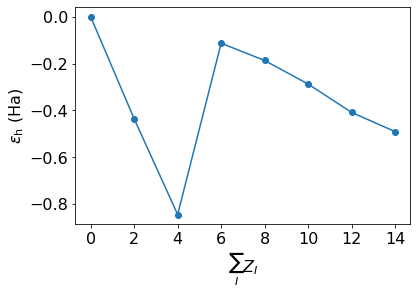

In [7]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(0, 16, 2), e_homos, '-o')
ax.set_xlabel(r'$\sum_I Z_I$')
ax.set_ylabel(r'$\epsilon_{\rm{h}}$ (Ha)')
ax.set_xticks(np.arange(0, 16, 2))
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/vacuum_reference/ehomo_vactoN2.png', bbox_inches='tight')

In [9]:
print('integration by trapezoidal rule')
display(Markdown(r'$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = ' + str(e_H2N_trapz)))
display(Markdown(r'$\Delta E_{\rm{ref}}$ = ' + str(eref_d1p5['N2'] - eref_d1p5['H2'])))
display(Markdown(r'$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = ' + str(e_H2N_trapz-(eref_d1p5['N2'] - eref_d1p5['H2']))))

print('integration by simpsons rule')
display(Markdown(r'$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = ' + str(e_H2N_simp)))
display(Markdown(r'$\Delta E_{\rm{ref}}$ = ' + str(eref_d1p5['N2'] - eref_d1p5['H2'])))
display(Markdown(r'$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = ' + str(e_H2N_simp-(eref_d1p5['N2'] - eref_d1p5['H2']))))

integration by trapezoidal rule


$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = -110.91340843476333

$\Delta E_{\rm{ref}}$ = -107.70621795299134

$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = -3.2071904817719883

integration by simpsons rule


$\Delta E$ (H$_2$ $\rightarrow$ N$_2$) = -110.74462035288622

$\Delta E_{\rm{ref}}$ = -107.70621795299134

$\Delta E (\rm{H}_2 \rightarrow \rm{N}_2)- \Delta E_{\rm{ref}}$ = -3.0384023998948777

#### Pairs of adjacent elements

In [10]:
element = 'N'
distance = 1.5
basis = 'def2-qzvp'
total_nelec = 14
num_elecs = np.array([0,2])
pairs = {'vactoH2':[], 'H2toHe2':[], 'He2toLi2':[], 'Li2toBe2':[], 'Be2toB2':[], 'B2toC2':[], 'C2toN2':[]}
alchs = []
ehs = []
for k in pairs.keys():
    if k == 'vactoH2':
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path([num_elecs[-1]], element, distance, basis, total_nelec)
        alchemical_potentials = np.concatenate((np.array([[0.0, 0.0]]), alchemical_potentials))
        e_homos = np.concatenate((np.array([0]), e_homos))
        e_lumos = np.concatenate((np.array([0]), e_lumos))
        e_nucs = np.concatenate((np.array([0.0]), e_nucs))     
    else:
        alchemical_potentials, e_homos, e_lumos, e_nucs = sample_path(num_elecs, element, distance, basis, total_nelec)
    alchs.append(alchemical_potentials)
    ehs.append(e_homos)
    dN = num_elecs[-1] - num_elecs[0]
    dZ = dN/2
    lam_vals = get_lam_vals(num_elecs)
    e_X2toY2_simp = get_energy(lam_vals, alchemical_potentials[:,0], e_nucs[-1], e_homos, dZ, dN) - e_nucs[0]
    pairs[k].append(e_X2toY2_simp)
    num_elecs = num_elecs + 2 #raise to get correct number for next pair of diatomics

/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/pyscf/gto/mole.py:1047: UserWarning: Function mol.dumps drops attribute charge because it is not JSON-serializable
  warnings.warn(msg)


In [11]:
# add reference delta
for k in pairs.keys():
    diatomics = k.split('to')
    pairs[k].append(eref_d1p5[diatomics[1]]-eref_d1p5[diatomics[0]])
    pairs[k].append(pairs[k][0]-pairs[k][1])


In [12]:
sum_ = 0
for k in pairs.keys():
    sum_ += pairs[k][0]
sum_

-112.2906473509857

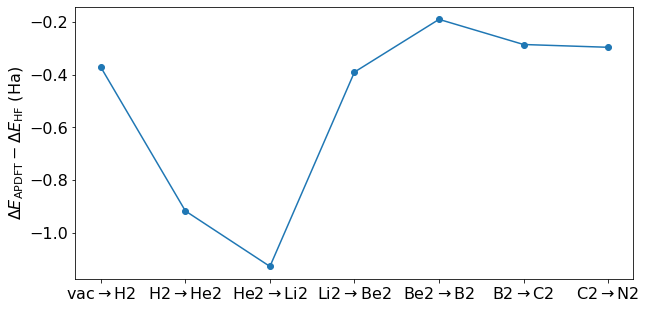

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
x = np.arange(1, 15, 2)
dE = []
for k in pairs.keys():
    dE.append(pairs[k][2])
ax.plot(x, dE, '-o')
ax.set_xticks(x)
xstring = [r'vac$\rightarrow$H2', r'H2$\rightarrow$He2', r'He2$\rightarrow$Li2', r'Li2$\rightarrow$Be2', r'Be2$\rightarrow$B2', r'B2$\rightarrow$C2', r'C2$\rightarrow$N2']
ax.set_xticklabels(xstring, fontsize=16)
ax.set_ylabel(r'$\Delta E_{\rm{APDFT}} - \Delta E_{\rm{HF}}$ (Ha)')
# plt.savefig('/home/misa/projects/Atomic-Energies/figures/vacuum_reference/error_stepwise_intg_N2.png', bbox_inches='tight')

largest error for intervals involving He2 
sudden change in e_homo from He2 to Li2 probably not main problem because for H2$\rightarrow$He2 large error as well although change in e_homo very smooth